This page demonstrates the current functionality of [Rhodium](https://github.com/Project-Platypus/Rhodium), a Python library for exploratory modelling and robust decision making. This demo is based off an example from the original Rhodium documentation by Dave Hadka.

## Load Rhodium Library
Let's begin by importing the necessary libraries. We also adjust some plotting options to improve the appearance of plots in your web browser.

In [ ]:
## Install necessary packages (installed online not on your machine)
## This will take a minute and will display a lot of text below. 
!pip install rhodium
!pip install SALib
!pip install ema_workbench
!pip install seaborn

In [ ]:
## Import packages that will be used in this demo
# Numpy is used for basic vector math operations
import numpy as np

# Scipy is used to find roots of an equation in the model
from scipy.optimize import brentq as root

# Rhodium is the MOEA used for optimization and visualization
from rhodium import *

# plotting options
%matplotlib inline
%matplotlib notebook
sns.set()
sns.set_style('darkgrid')

## Defining the Model
Next, we define our model. The model can be any Python function, with any number of input arguments. The names of the input arguments will become important later. The model can also return any number of outputs. For this example, we will use the lake problem. Recall that the flux of phosphorus into the lake is defined by the following differential equation:

![equilibrium.png](https://raw.githubusercontent.com/TrevorJA/Rhodium-CEE5980Demo/master/LakeProblemModel.png)

In [2]:

### This function is the "model" which simulates the lake system

def lake_problem(pollution_limit, # Lever, how much phosphorus can be emitted each year?
         b = 0.42,        # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,         # recycling exponent
         mean = 0.02,     # mean of natural inflows
         stdev = 0.001,   # standard deviation of natural inflows
         alpha = 0.4,     # utility from pollution
         delta = 0.98,    # future utility discount rate
         nsamples = 100): # monte carlo sampling of natural inflows)
    
    # Find the tipping points
    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    # create an array to store phosphorus in the lake at each timestep
    nvars = len(pollution_limit)
    X = np.zeros((nvars,))
    
    # initialize array to store ave phosphorus and reliability variables
    average_daily_P = np.zeros((nvars,))
    reliability = 0.0
    
    # create array to store anthropogenic emissions for each timestep
    decisions = np.array(pollution_limit)

    # monte carlo over nsamples
    for _ in range(nsamples):
        X[0] = 0.0
        
        # each monte carlo sample has a differnt set of natural inflows
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        # simulate system over 100 years
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        # calculate objectives
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    intertia = np.sum(np.diff(decisions) > -0.02)/float(nvars-1)
    
    return (max_P, utility, intertia, reliability)

Next, we define a Rhodium model. A Rhodium model provides additional annotations for the function above. In particular, we will identify all parameters (inputs) and responses (outputs) of interest. Note that each parameter specified must be an input to the lake problem function (above) but not all inputs to the function must be Rhodium parameters, only relevent uncertainties and levers should be coded as Rhodium model parmeters.

In [3]:
model = Model(lake_problem)

model.parameters = [Parameter("pollution_limit"),
                    Parameter("b"),
                    Parameter("q"),
                    Parameter("mean"),
                    Parameter("stdev"),
                    Parameter("delta")]

model.responses = [Response("max_P", Response.MINIMIZE),
                   Response("utility", Response.MAXIMIZE),
                   Response("inertia", Response.MAXIMIZE),
                   Response("reliability", Response.MAXIMIZE)]

Parameter names must match the argument name in the Python function. You can also define default values for parameters, but it will fall back to using any default values in the function definition. Responses identify the model outputs. In addition to providing a name for each response, you can also specify if the response is an objective to be minimized or maximized, or indicate the response is "informational" and should not be optimized.

Rhodium also supports constraints. For example, we could define a constraint on reliability. Note how the constraint is a valid Python expression that can reference any parameter or response. You should in general try to keep each constraint simple, such as simple equality or inequality expressions, which will help improve the performance of the optimization algorithm.

In [4]:
model.constraints = [Constraint("reliability >= 0.95")]

Or we could have an unconstrained problem, in which case we simply do not define any constraints:

In [ ]:
model.constraints = []

At this point, the model is ready for use with Rhodium.

The following sections will illustrate the Many Objective Robust Decision Making (MORDM) framework applied to the lake problem.

![MORDM.png](https://raw.githubusercontent.com/TrevorJA/Rhodium-CEE5980Demo/master/MORDM_framework.png)

## Optimizing the Model
The first step in a MORDM analysis is to search for non-dominated decision alternatives. Rhodium will attempt the optimize the responses we defined subject to any constraints by tweaking levers. Levers are parameters that we can control when implementing a policy. For the lake problem, we are controlling the amount of pollution released yearly into the lake. Thus, we will define a lever for our `pollution_limit` parameter to be 100 values between 0.0 and 0.1.

In [ ]:
model.levers = [RealLever("pollution_limit", 0.0, 0.1, length=100)]

Next, we call `optimize` to optimize the problem. The optimization algorithm will iteratively adjust the levers while searching for an optimal policy. If more than one response is defined, such as in this example, then typically many Pareto optimal responses can be found. None of the identified Pareto optimal policies is better than any other; instead they form a tradeoff among the responses, some with better performance with respect to one or more responses but worse in others. Running the optimization below, we should find many optimal policies.

The `optimize` function call takes 3 arguments: the simulation model, your MOEA of choice and the number of function evaluations to run. Here we will optimize the lake probem using the NSGAII algorithm over 1,000 function evaluations.

In [ ]:
output = optimize(model, "NSGAII", 1000)
print("Found", len(output), "optimal policies!")

The output is by default a dictionary. However, for some analyses, it can be useful to have this data in other formats, such as Pandas' DataFrame and Numpy's ndarray. Rhodium can also convert its data sets into these other formats:

In [ ]:
# Save the output as a pandas dataframe
df = output.as_dataframe()
# Save the output as a numpy array
arr = output.as_array()

Here, `output` is a Rhodium data set containing one or more optimal policies. We can reference specific policies by index, such as `output[5]`, or by searching for a policy with certain traits using the `find`, `find_min`, and `find_max` methods. For example:

In [ ]:
policy = output[5]
policy = output.find_max("reliability")
policies = output.find("utility > 0.5")

As demonstrated above, a Rhodium data set acts like a list with additional methods for querying data. Each entry (aka policy) within the dataset is a Python dictionary mapping keys to values. The key corresponds to the name of the parameter or response we defined in the model. For example, we can print information about a selected policy:

In [ ]:
policy = output.find_max("reliability")

print("Max Phosphorus in Lake:", policy["max_P"])
print("Utility:               ", policy["utility"])
print("Inertia:               ", policy["inertia"])
print("Reliability:           ", policy["reliability"])

We can also use the `apply` method to perform calculations on the data. The expression can reference any keys (the parameters and responses) that are defined in the policy.

In [ ]:
result = output.apply("sum(pollution_limit)")

Here, the `apply` method returns a list storing the sum of the yearly pollution limits for each policy. If we instead use an assignment in the expression, as shown below, we can calculate and add a new field to the dataset.

In [ ]:
output.apply("total_pollution = sum(pollution_limit)");
policy = output.find_min("total_pollution")
print("Total Pollution generated:         ", policy['total_pollution'])

## Visualizing Optimization Results
While Rhodium provides many tools to manipulate, query, and explore the raw data, it is often more convenient to inspect the results visually. For example, here are the Pareto optimal policies in a 2D scatter plot:

In [ ]:
%matplotlib inline
fig = scatter2d(model, output, c='reliability', s='inertia')

Rhodium by default assumes that it should plot the model responses. These responses are automatically plotted on the x, y, z (for 3D plots), color, and size axes. This can be customized.

In the cells below, examine the optimization results across the discovered solutions. Try editing the colormaps you plot and changing the way the objectives are ordered.

The following visualization types are available:
- **2D Scatter Plot**: `scatter2d(model, output, c='objective3', cmap='RdBu' s='objective4)`

- **3D Scatter Plot**: `scatter3d(model, output, c='objective4', cmap ='PuOr', s='objective1')`

- **Parallel Coordinate Plot**: `parallel_coordinates(model, output, colormap="jet", target="top")`

- **Pairwise Scatter Plot**: `pairs(model, output)`

- **Kernel Density Contour Plot**: `kdeplot(model, output, x="objective1", y="objective2")`

- **Joint Plot**: `joint(model, output, x="objective1", y="objective2")`

In [ ]:
fig = scatter3d(model, output, c='reliability', cmap='RdBu')

In [ ]:
fig = parallel_coordinates(model, output, colormap = 'RdBu', target = 'top',
                brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")])

In [ ]:
fig = scatter2d(model, output, x="reliability", y="max_P")

Try plotting some of your own figures below:

In [ ]:
fig = 

In [ ]:
fig = 

It is also possible to group or classify policies together using brushing. Brushing in Rhodium uses Python expressions to match the policies of interest. When plotting with brushes, the points will be highlighted if they match the brush:

In [ ]:
fig = scatter2d(model, output,brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")])

Brushing includes several additional options, such as allowing additional control over the plotting (e.g., setting color or point size). It is possible to define more than one brush, any points not painted by a brush will appear as "Unassigned".

As demonstrated above, brushing can be added to any of the available plotting tools, simply add the argument:

`brush=[Brush("criteria > value"), Brush("criteria <= value")]`

Try brushing the plots you made above to various criteria, ie. reliability>0.2 or utility <0.8.

In [ ]:
fig = 

In [ ]:
fig = 

## Sensitivity Analysis
Rhodium automates the task of performing global and regional sensitivity analysis on the model uncertainties. Rhodium provides a convenient wrapper on top of Python's [SALib](https://github.com/SALib/SALib/), allowing you to specify only the model, the response of interest, an optional policy you want to investigate, and details on the sensitivity analysis method.

Using optimization, we leveraged an automated search procedure to identify optimal policies for our model. We can also manually explore different policies. Recall that a policy is simply a Python dictionary with keys mapping to our parameters. We can construct new policies by creating dictionaries with whatever parameters we wish to control. For example, here is a policy where we allow a yearly pollution level of 0.02:

In [ ]:
policy = {"pollution_limit" : [0.02]*100}

We can use the `evaluate` method to evaluate the policy and display the responses:

In [ ]:
result = evaluate(model, policy)

print("Max Phosphorus in Lake:", result["max_P"])
print("Utility:               ", result["utility"])
print("Inertia:               ", result["inertia"])
print("Reliability:           ", result["reliability"])

The results in the cell above represent the policy's performance under an assumed set of model parameters. Sensitivity analysis allows us to quantify the effects of uncertainty within these parameters on model responses. To perform sensitivity Analysis, Rhodium must be told the uncertainties within the model and their bounds.
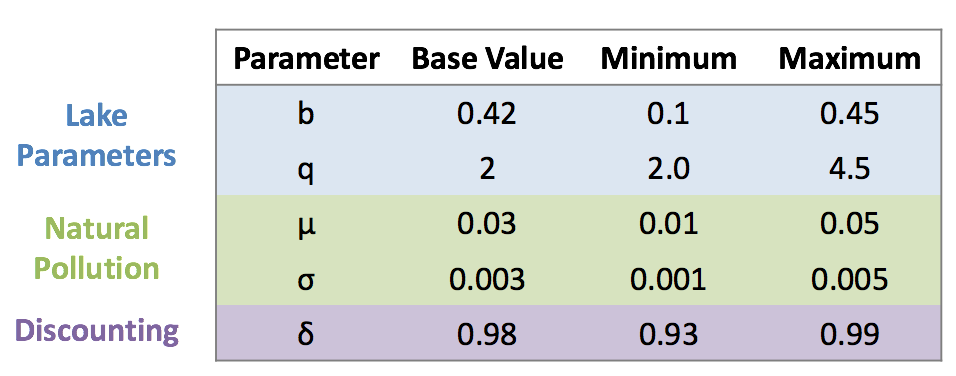

In [ ]:
model.uncertainties = [UniformUncertainty("b", 0.1, 0.45),
                       UniformUncertainty("q", 2.0, 4.5),
                       UniformUncertainty("mean", 0.01, 0.05),
                       UniformUncertainty("stdev", 0.001, 0.005),
                       UniformUncertainty("delta", 0.93, 0.99)]

We'll start our sensitivity analysis with the Method of Morris to identify the sensitive parameters with respect to reliability. The Method of Morris returns the elementary effects of each uncertain parameter in the model, a global measure of first order sensitivity.

In [ ]:
result = sa(model, "reliability", policy=policy, method="morris", nsamples=1000, num_levels=4, grid_jump=2)
print(result)

Parameters `b`, `q`, and `mean` exhibit the largest sensitivites. The method of Morris only analyzes the effects of parameters in isolation. To understand interactive effects between uncertainties, the Sobol method lets us also compute second-order and total-order indices, capturing the interactions between parameters:

In [ ]:
result = sa(model, "reliability", policy=policy, method="sobol", nsamples=1000)
print(result)

Rhodium allows us to visualize the results from sensitivity analysis. Below we plot the first and total-order sensitivity indices for the Sobol method. Similar 2D bar plots can be shown for all other supported methods.

In [ ]:
fig = result.plot()

If using Sobol's method, we can also generate a "spider" or "radial" plot showing the second-order indices. In the figure below, the first and total-order indices for each parameter are indicated by the solid circle and the outer ring, respectively, where a larger radius indicates larger effects. The gray lines connecting the circles represents the second-order indices, with thicker lines corresponding to larger second-order effects.

In [ ]:
fig = result.plot_sobol(threshold=0.01)

If you have a plot with a large number of parameters, it can be useful to visually group similar parameters. For example:

In [ ]:
fig = result.plot_sobol(threshold=0.01,
                        groups={"Lake Parameters" : ["b", "q"],
                                "Natural Pollution" : ["mean", "stdev"],
                                "Discounting" : ["delta"]})


The global sensitivity analysis demonstrated above is useful for identifying the key parameters and their interactions. To understand what values of our parameters cause changes in performance, we can use one-at-a-time (OAT) or regional sensitivity analysis to explore each parameter in detail. In OAT sensitivity analysis, we fix all parameters at their default value except one. For this one parameter, we then sample across its entire range and observe how the response of interest changes.

In [ ]:
fig = oat(model, "reliability", policy=policy, nsamples=1000)

The plot above shows on the left the percentage of total variance caused by each parameter. We see that `b` and `q` contribute most to the variance. On the right we see a line plot showing how the response of interest (reliability) changes as the sampled parameter changes. Take `b`, for example, shown in blue. `b` approches 100% reliability as its value increases. On the other hand, the mean level of pollution, `mean`, causes a substantial reduction in reliability as the value increases.

You may have also noticed that `q` has no effect here, contrary to what we saw from global sensitivity analysis. Recall that OAT sensitivity analysis fixes all but one parameter at their default value. This indicates that `q` has little to no effect when the other parameters are fixed at their default. But since we observed large sensitivites from `q` from global sensitivity analysis, one would expect `q` would become more significant if the other parameters deviate from their default.

In the cells below, complete the functions to perform sensitivity analysis on a different objective. Do sensitivities change?

In [ ]:
result = sa()

In [ ]:
fig = result.plot()

## Scenario Discovery
We can also use Rhodium for exploratory analysis and scenario discovery. To this end we will evaluate the performance of our simple policy created above over a large sample of plausible States Of the World (SOW). Each SOW represents some combination of the uncertainty parameters. Here, we generate 1000 SOWs via Latin Hypercube Sampling (LHS):

In [ ]:
# these are the same uncertainties as above, just repeating for clarity
model.uncertainties = [UniformUncertainty("b", 0.1, 0.45),
                       UniformUncertainty("q", 2.0, 4.5),
                       UniformUncertainty("mean", 0.01, 0.05),
                       UniformUncertainty("stdev", 0.001, 0.005),
                       UniformUncertainty("delta", 0.93, 0.99)]

SOWs = sample_lhs(model, 1000)

Then, using the `evaluate` method, we evaluate our policy in each SOW. To do this, we need to combine our SOWs with our fixed policy. Using the update function, we update each SOW with the parameters defined in our policy, namely the fixed `pollution_limit` we specified previously.

In [ ]:
results = evaluate(model, update(SOWs, policy))

It can be cumbersome to explore the results from the 1000 SOWs separately. Instead, let's assume we are really only interested in SOWs where our policy achieved a reliability of 90% or greater (conversely, we could be interested in SOWs where our system failed with poor reliability). We "classify" each SOW as "Reliable" or "Unreliable":

In [ ]:
classification = results.apply("'Reliable' if reliability > 0.9 else 'Unreliable'")

Now we will use the [Patient Rule Induction Method (PRIM)](https://github.com/Project-Platypus/PRIM) to identify the key uncertainties that cause a SOW to fall within either class. This process is termed "scenario discovery". PRIM works by restricting the dimensions (bounds) for each uncertainty that contains the SOWs of interest. We refer to these restrictions as a "box".

PRIM is an iterative process. We call `find_box()` followed by `box.show_tradeoff()` to display visually the dimension restrictions in terms of two metrics: coverage and density. Coverage measures the percentage of cases of interest contained within the box and density considers the percentage of cases within the box that are of interest. Having a coverage and density of 100% is ideal. Note we provide the `coi` argument to indicate we are interested in solutions classified as "Reliable".

In [ ]:
p = Prim(results, classification, include=model.uncertainties.keys(), coi="Reliable")
box = p.find_box()
fig = box.show_tradeoff()

Each point in the above plot represents a sequence of restrictions on the dimensions (a peeling trajectory). Typically, as we restrict each dimension further, we improve density but reduce coverage. We can view the details on a specific peeling trajectory by first selecting the i-th trajectory with `box.select(i)` and running:

In [ ]:
print(box)

If you're running this example directly from Python, you can also run `box.show_details()` to produce a nicely formatted visual display of the box limits, the covered SOWs, and the box statistics. See [here](https://github.com/Project-Platypus/PRIM/blob/master/docs/images/screenshot2.png) for an example.

Classification and Regression Trees (CART) is an alternative method for scenario discovery. Unlike PRIM, which produces a single box containing the cases of interest, CART can form disjoint partitions of the dataset. As such, it tends to offer better classification rates at the expensive of interpretability (the partitions can become complex and difficult to understand).

Note: If you have a mac you may have an issue viewing the CART Tree, see [this link](https://github.com/davidfgold/Rhodium/blob/master/INSTALL.md#troubleshooting) for troubleshooting. CART has still run, but there is a versioning issue with the visualization on Macs.

In [ ]:
c = Cart(results, classification, include=model.uncertainties.keys(), min_samples_leaf=50)

The graphic above shows each recursive partition identified by CART, color-coded by their classification. We can also print the contents of the tree. If the case of interest (`coi`) is specified, then it prints only those nodes with the given class, letting you compare the density and coverage of a node (including intermediate nodes) as we did with PRIM. It also prettifies the rules as shown below.

In [ ]:
c.print_tree(coi="Reliable")

## Conclusion
Rhodium is a powerful tool for analyzing and exploring a model. We demonstrated connecting Rhodium to the Lake Problem model written in Python. Rhodium also supports tools for connecting to models written natively (and compiled into a dynamically-linked library or shared object), Excel models, and more. Please visit our [GitHub page](https://github.com/Project-Platypus/Rhodium) to learn more, see the [examples](https://github.com/davidfgold/Rhodium/tree/master/examples) section for further demonstration of Rhodium.